In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("DS_Emp.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


In [3]:
print(df.dtypes)

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                      int64
dtype: object


In [4]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [5]:
df = df.drop("enrollee_id", axis=1)

In [6]:
df['gender'] = df['gender'].fillna('Unknown')
df['enrolled_university'] = df['enrolled_university'].fillna('Unknown')
df['education_level'] = df['education_level'].fillna('Unknown')
df['major_discipline'] = df['major_discipline'].fillna('Unknown')
df['experience'] = df['experience'].fillna('Unknown')
df['company_size'] = df['company_size'].fillna('Unknown')
df['company_type'] = df['company_type'].fillna('Unknown')
df['last_new_job'] = df['last_new_job'].fillna('Unknown')

In [7]:
label_cols = [
    'gender','relevent_experience','enrolled_university',
    'education_level','major_discipline','experience',
    'company_size','company_type','last_new_job','city'
]

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [8]:
scaler = StandardScaler()
df[['city_development_index', 'training_hours']] = scaler.fit_transform(
    df[['city_development_index', 'training_hours']]
)

In [9]:
X = df.drop("target", axis=1)
y = df["target"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (15326, 12)
Testing shape: (3832, 12)


In [13]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Predict on test set
y_pred = log_model.predict(X_test)

# Evaluate model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.7706158663883089

Confusion Matrix:
[[2689  191]
 [ 688  264]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2880
           1       0.58      0.28      0.38       952

    accuracy                           0.77      3832
   macro avg       0.69      0.61      0.62      3832
weighted avg       0.74      0.77      0.74      3832



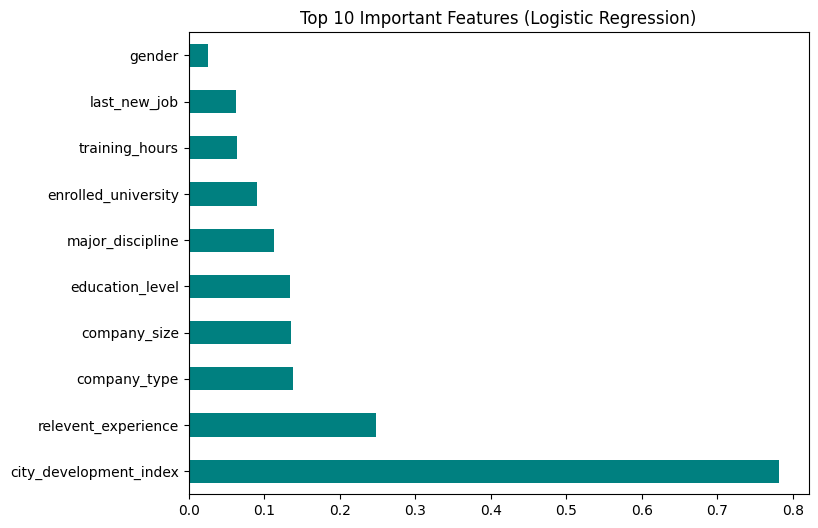

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get feature importance from logistic regression (absolute value of coefficients)
feature_importances = pd.Series(np.abs(log_model.coef_[0]), index=X_train.columns)

# Plot top 10
plt.figure(figsize=(8,6))
feature_importances.nlargest(10).plot(kind='barh', color="teal")
plt.title("Top 10 Important Features (Logistic Regression)")
plt.show()


In [19]:
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],   # liblinear supports l1 and l2
        'max_iter': [500, 1000]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],        # saga supports elasticnet
        'l1_ratio': [0.3, 0.5, 0.7],  # only used for elasticnet
        'max_iter': [500, 1000]
    }
]


In [20]:
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

best_lg = grid_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'C': 100, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 Score: 0.3782946445289197


In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict with the best logistic regression model
y_pred_best = best_lg.predict(X_test)

# Evaluate
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_best))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Logistic Regression Test Accuracy: 0.7706158663883089

Confusion Matrix:
[[2689  191]
 [ 688  264]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2880
           1       0.58      0.28      0.38       952

    accuracy                           0.77      3832
   macro avg       0.69      0.61      0.62      3832
weighted avg       0.74      0.77      0.74      3832

